# 1 - Introduction

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import fundamental libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import dedicated libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, seasonal_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from prophet import Prophet
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# -----------DEFINE DEFAULT PARAMETERS OF MATPLOTLIB---------------
# Set the DPI (dots per inch) for the figures
plt.rcParams["figure.dpi"] = 100
# Set the default figure size for plots
plt.rcParams["figure.figsize"] = (12,5)
# Enable gridlines on the axes of plots
plt.rcParams["axes.grid"] = True
# -----------------------------------------------------------------

/kaggle/input/total-sales-local-store/public_data.csv


# 2 - Get the data
The information is taken directly from a .CSV file obtained through SQL. Once the predictive model is generated, a connector will be designed with the Queries necessary for the implementation in production of the model.

In [3]:
# Read CSV DATA
df = pd.read_csv('/kaggle/input/total-sales-local-store/public_data.csv')
df.head()

,ID,DATE,AMOUNT,TAXES
0,DVC000001,15/08/2014,43.1,6.90
1,DVC000002,15/08/2014,180.0,28.80
2,DVC000003,18/08/2014,180.0,28.80
3,DVC000004,19/08/2014,544.0,87.04
4,DVC000005,22/08/2014,2678.0,428.48


In [4]:
# Get dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68482 entries, 0 to 68481
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      68482 non-null  object 
 1   DATE    68482 non-null  object 
 2   AMOUNT  68482 non-null  float64
 3   TAXES   68482 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.1+ MB


In [5]:
# Print relevan information about the dataset
print(f"Values in ID (all inputs): {len(df['ID'].unique())}")
print(f"Labels in ID: {df['ID'].str[:3].unique()}")
print(f"Number of different dates: {len(df['DATE'].value_counts())}")

Values in ID (all inputs): 68482
Labels in ID: ['DVC' 'DVE' 'DVM' 'DVT' 'CUL' 'ENS' 'ESN' 'MXL' 'T00' 'TIJ']
Number of different dates: 2233


## 2.1 - Columns description
- **ID**: Unique values, sales folio with the initials *'DVC', 'DVE', 'DVM', 'DVT', 'CUL', 'ENS', 'ESN', 'MXL', ' T00','TIJ'* referring to the store
- **DATE**: Date of the transaction, repeated values, format *'YYYY-MM-DD'* (there are days without transactions)
- **AMOUNT**: Amount without taxes (MXN)
- **TAXES**: Item tax (the total is **SALES_AMOUNT** + **SALES_TAXES**) (MXN)


## 2.2 - Data cleaning
In the first instance, the focus will be solely on the time series, that is, only through the sales history without considering exogenous variables (maybe removable from the folio). If this fails they will be used in a more complex model.

In [6]:
# Extract DATE and TOTAL (price + taxes) and save it in dictionary
data = {'DATE': df['DATE'].values, 'TOTAL':(df['AMOUNT'].values + df['TAXES'].values)}

# Create a new DataFrame from dictionary
hist = pd.DataFrame(data=data)

In [7]:
# Get the total sell by day and set FECHA as index
hist = hist.groupby(by='DATE',sort=True).sum()
# Set index to datetime64 datatype
hist.index = pd.to_datetime(hist.index,format='%d/%m/%Y')
hist.head()

,TOTAL
DATE,
2017-02-01,63554.97
2018-02-01,81243.64
2019-02-01,137842.29
2022-02-01,60626.35
2023-02-01,104112.09


A validation is never too much:

# 3 - Exploratory data analysis
It seeks to better understand the behavior of sales, especially if there is any trend, temporality, pattern, etc. This allows the proper selection of a learning model and, above all, a better understanding of the sales.

In [8]:
def date_units_missing(df,freq):
    """
    Check for missing date units in a DataFrame based on a given frequency.

    Args:
        df (DataFrame): The DataFrame to check for missing date units.
        freq (str or DateOffset): The frequency to check for missing units.

    Returns:
        None
    """
    
    # Generate the date range based on the minimum and maximum dates in the DataFrame
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(),freq=freq)
    
    # Find the missing dates that are not present in the DataFrame index
    missing_dates = date_range[~date_range.isin(df.index)]
    missing_len = len(missing_dates)

     # Check if there are missing dates and print the corresponding message
    if missing_len > 0:
        print(f"Missing {missing_len} {freq} in the DataFrame, this is {round(missing_len / len(date_range) * 100,2)}% of the total")
    else:
        print(f"No missing {freq} in the DataFrame.")

**Not every day sales were made** (or there are no records in the database), therefore it is not recommended to use it as a unit of the time series.

In [9]:
# Check missing dates (DAYS)
date_units_missing(hist,'D')

Missing 972 D in the DataFrame, this is 30.33% of the total


Instead, it is possible **to group the sales by week** (no week closed its sales at zero)

In [10]:
# Check missing dates (WEEKS)
hist_w = hist.resample('W').sum()
date_units_missing(hist_w,'W')

No missing W in the DataFrame.


or by month

In [11]:
# Check missing dates (MONTHS)
hist_m = hist.resample('M').sum()
date_units_missing(hist_m,'M')

No missing M in the DataFrame.


And of course for quarter of year

In [12]:
# Check missing dates (QUARTER)
hist_q = hist.resample('Q').sum()
date_units_missing(hist_q,'Q')

No missing Q in the DataFrame.


# 3.1 - Timeseries graph
There does not seem to be a clear trend in the data, however, the graph suggests that from mid-2019 strong sales were made in some weeks that at first glance do not show a clear pattern either. The monthly behavior presents less measurement noise.

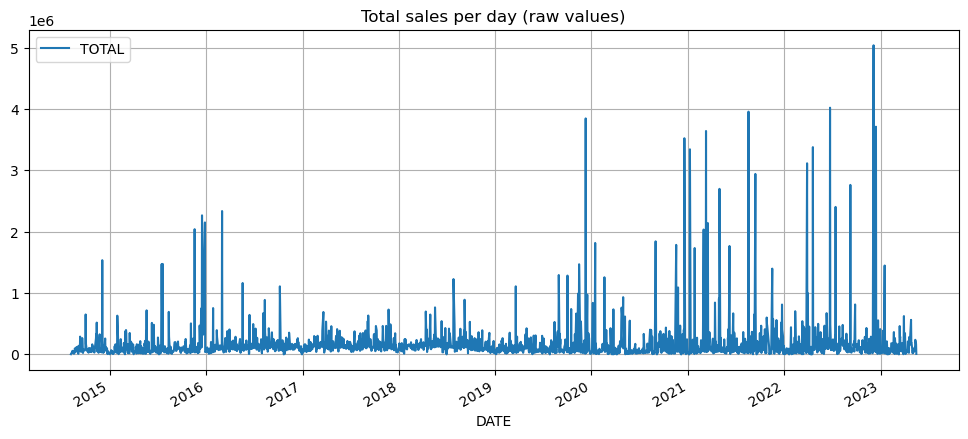

In [13]:
hist.plot(title='Total sales per day (raw values)');

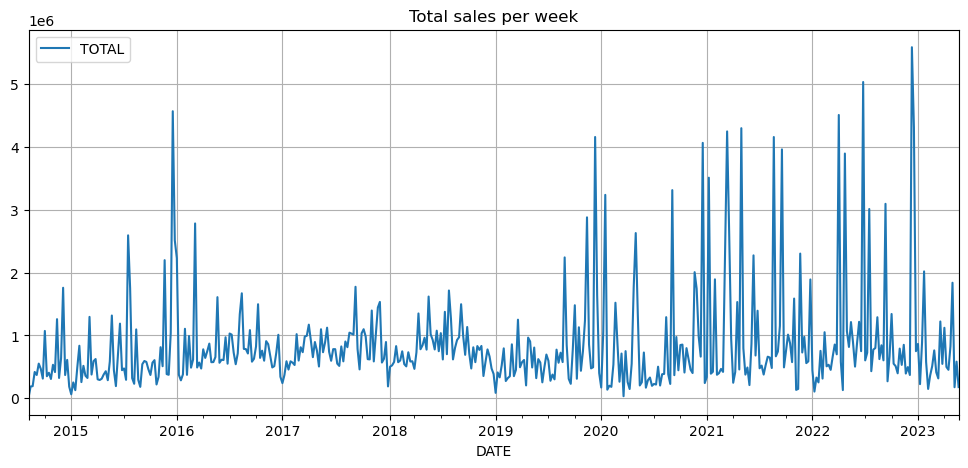

In [14]:
# Plot all week data
hist_w.plot(title='Total sales per week');

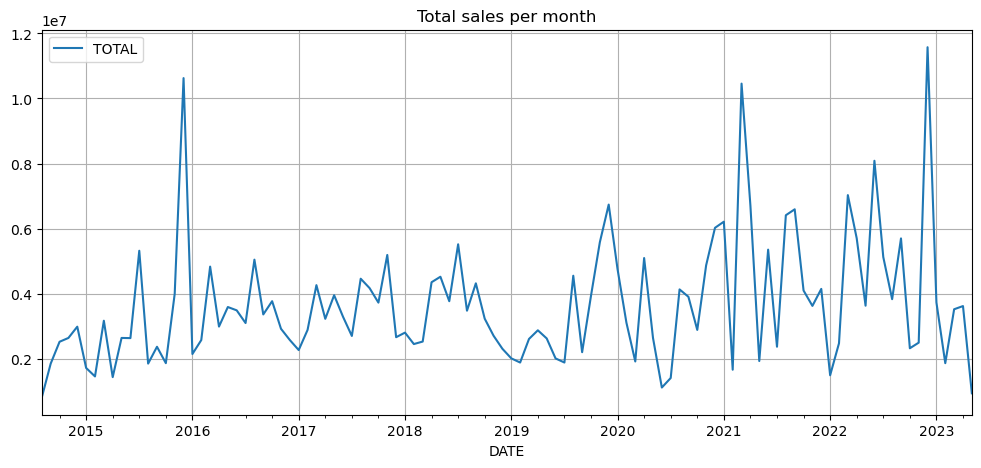

In [15]:
# Plot all month data
hist_m.plot(title='Total sales per month');

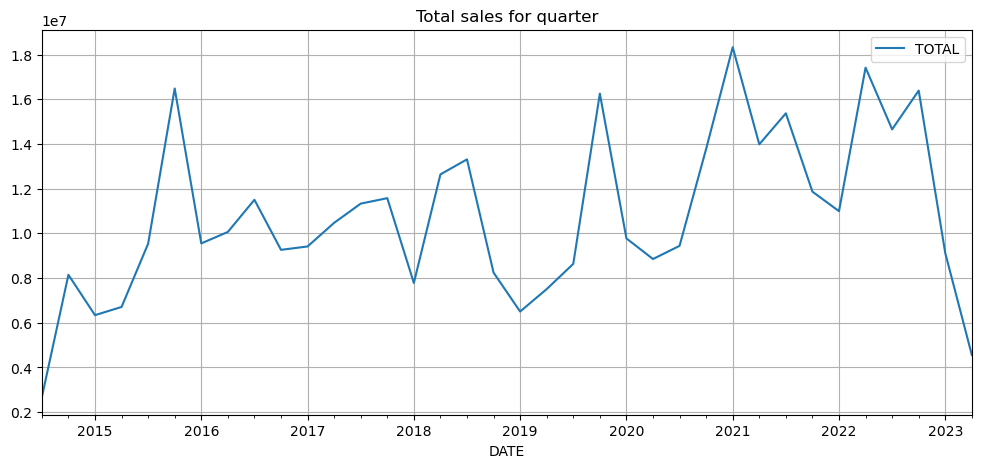

In [16]:
# Plot all quarter data
hist_q.plot(title='Total sales for quarter');

The average weekly sale of the entire data set is 845e3 MXN with a standard deviation of 792e3 MXN and maximum and minimum values of 5.58 millions MXN and 17 thousand MXN. This dispersion warns that it will be difficult to generate an accurate model.

In [17]:
hist_w.describe()

,TOTAL
count,4.590000e+02
mean,8.463188e+05
std,7.921084e+05
min,1.723120e+04
25%,4.195077e+05
50%,6.176827e+05
75%,9.236854e+05
max,5.582043e+06


## 3.2 - Trend, stationarity and seasonality

### 3.2.1 - Trend via SMA
The simple moving average is plotted to find the trend of the data

**IMPORTANT**:
The quarterly and semi-annual simple moving average (SMA) shows a slight upward trend. On the other hand, the annual SMA shows a clearer increase (linear to the naked eye) from the third quarter of 2019. No seasonality are observed.

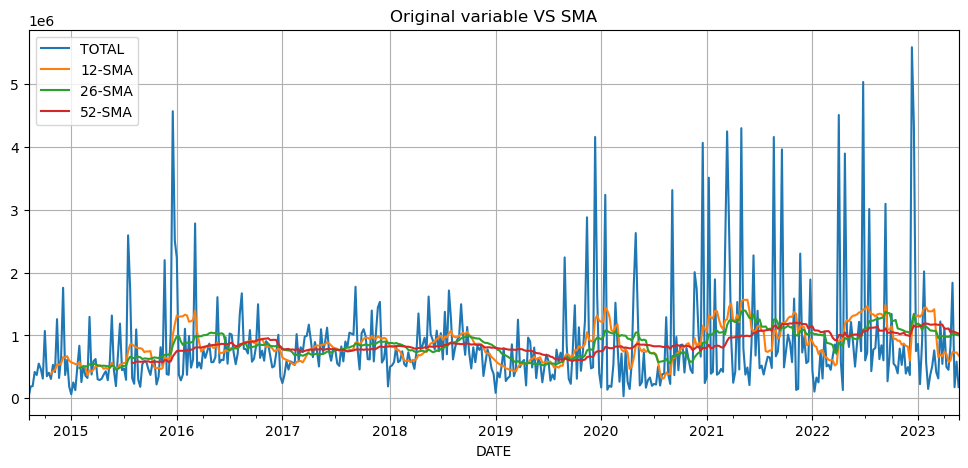

In [18]:
# Rolling by 6 months, quarter and a year to calculate the moving average (MA)
hist_w.plot(title='Original variable VS SMA')
hist_w['TOTAL'].rolling(window=12).mean().plot(legend=True,label='12-SMA')
hist_w['TOTAL'].rolling(window=26).mean().plot(legend=True,label='26-SMA')
hist_w['TOTAL'].rolling(window=52).mean().plot(legend=True,label='52-SMA');

With total sales we have a clearer idea of the problem complexity. The company had a more or less linear growth from 2015 to 2017, followed by a linear decrease from 2017 to 2019. However, after its low point in 2019, it started with exponential growth until 2021 where sales remained constant until 2022 (This is exclusively in total annual sales).
- *What happened in 2019? any sales strategy?, external phenomenon or maybe the pandemic?*
- *Why did growth stop in 2021?* was liquidity prioritized?
- *The closing sales of 2021 are almost identical to those of 2022, why?*
- **There is the possibility that there are external and measurable factors with a direct impact on sales. INVESTIGATION REQUIRED**

These questions can help to better understand the sales strategy of the business and thus propose tools for decision making.

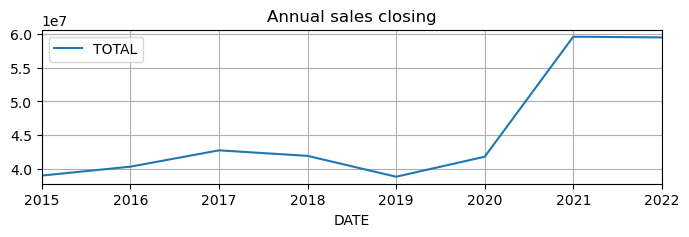

In [19]:
# Plot the annual sales closing data from '2015-01-01' to '2023-01-01'
hist.resample('A').sum().loc['2015-01-01':'2023-01-01'].plot(figsize=(8,2),title='Annual sales closing');

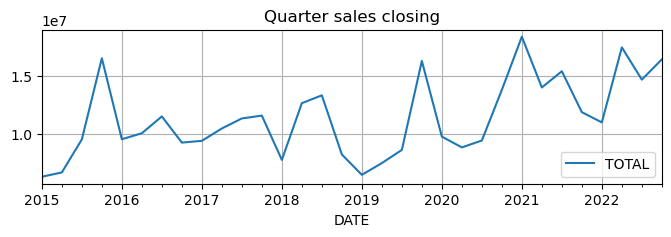

In [20]:
# Plot the quartet sales closing data from '2015-01-01' to '2023-01-01'
hist.resample('Q').sum().loc['2015-01-01':'2023-03-01'].plot(figsize=(8,2),title='Quarter sales closing');

The annual moving average barely showed a positive change in the sales trend, however, with the annual graph we know that the total is much higher than this average value. Therefore, the model has to be able to predict the peaks of the chart (weeks where strong sales were made). These weeks do not show a temporality (patterns), so advanced models are most likely required for this problem or else collect more information.

There is a possibility that the level of randomness of the sales is very high, if so it will not be possible to generate an accurate model.

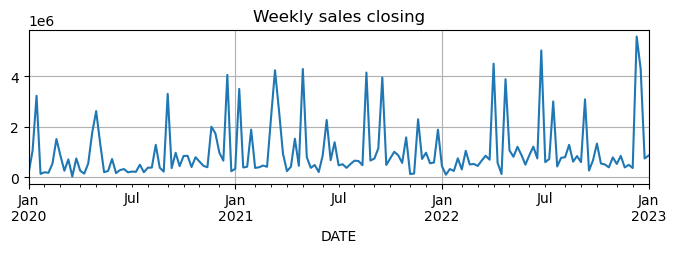

In [21]:
# Plot the weekly sales closing data from '2015-01-01' to '2023-01-01'
hist_w.loc['2020-01-01':'2023-01-01','TOTAL'].plot(figsize=(8,2),title='Weekly sales closing');

### 3.2.2 -  ETS decomposition (Error Tred Seasonal)
ETS decomposition shows a lower error (resid) with the multiplicative model. However, the trend is identical to the plot of the additive model and very similar to the semi-annual moving average. Furthermore, there is no clear evidence of a seasonal component

The "observed seasonality" suggests that sales reach their maximum just before the end of the year, however, this did not occur in 2016, 2017, 2018 and 2021. Likewise, it suggests that the minimum sales is at the beginning of the year, this is not correct for 2020 and 2021.

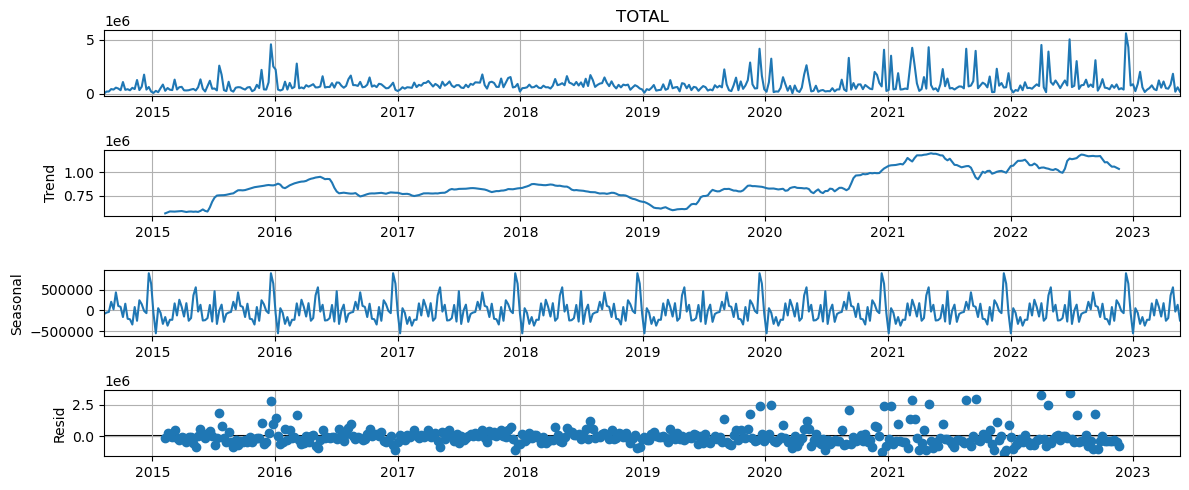

In [22]:
# Perform seasonal decomposition with additive decomp on the 'TOTAL' column of the 'hist_w' DataFrame
result = seasonal_decompose(hist_w['TOTAL'], model='add',period=52)
result.plot();

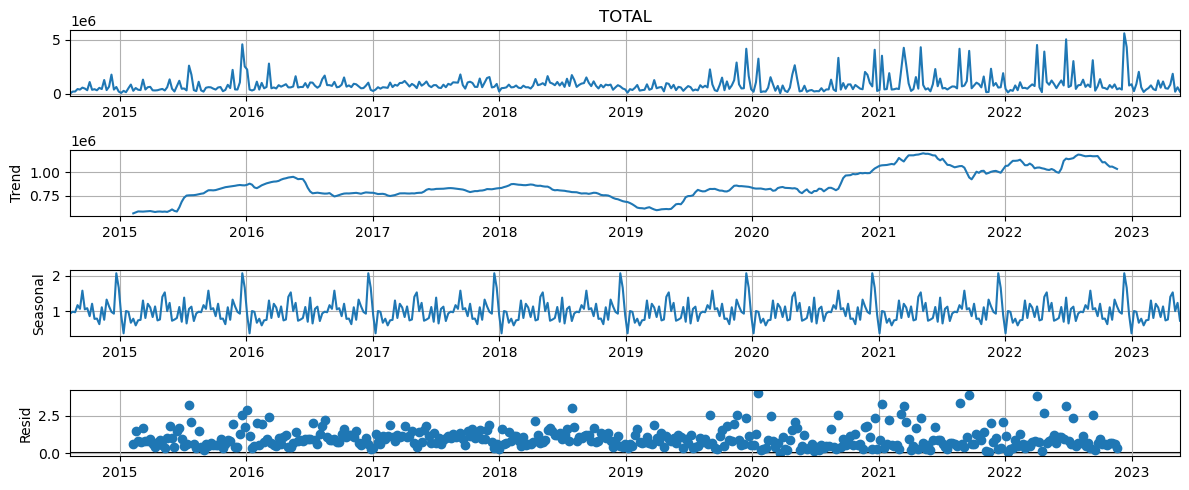

In [23]:
# Perform seasonal decomposition with multiplicative decomp on the 'TOTAL' column of the 'hist_w' DataFrame
result = seasonal_decompose(hist_w['TOTAL'], model='mul',period=52)
result.plot();

### 3.2.3 - Dickey-Fuller test
We are going to use a function to evaluate the stationarity

In [24]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    CREDITS: PIERIAN DATA
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

The test shows an extremely low p-value suggesting that the time series is stationary.

In [25]:
# Evaluate stationarity of the data
adf_test(hist_w['TOTAL'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.120587e+01
p-value                 2.185644e-20
# lags used             2.000000e+00
# observations          4.560000e+02
critical value (1%)    -3.444772e+00
critical value (5%)    -2.867899e+00
critical value (10%)   -2.570157e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 3.2.4 -  Graphs to determine the impact of the month or quarter
In general, it is observed that sales increase very slightly throughout the year, having its maximum in the last quarter. It is important to note that this is an average, it is not always fulfilled.

Text(0.5, 1.0, 'Average monthly sale')

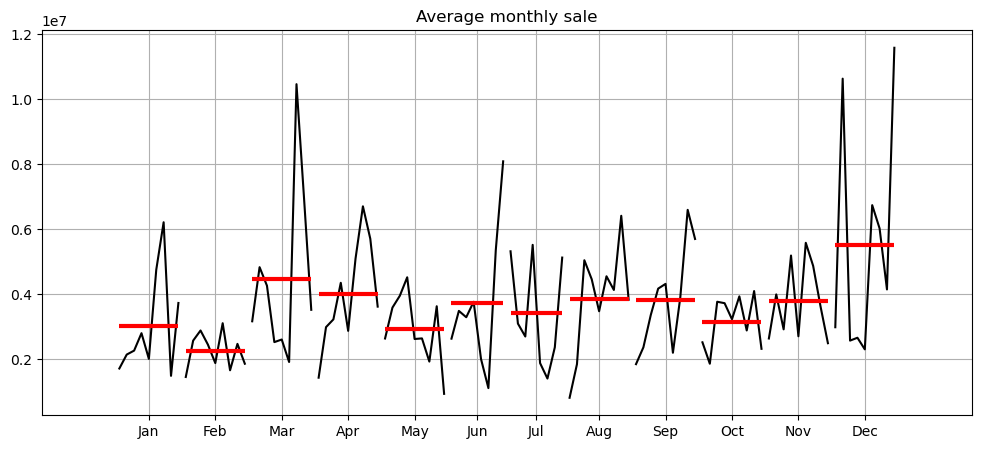

In [26]:
# Plot the monthly data using month_plot
month_plot(hist_m['TOTAL']);
plt.title('Average monthly sale')

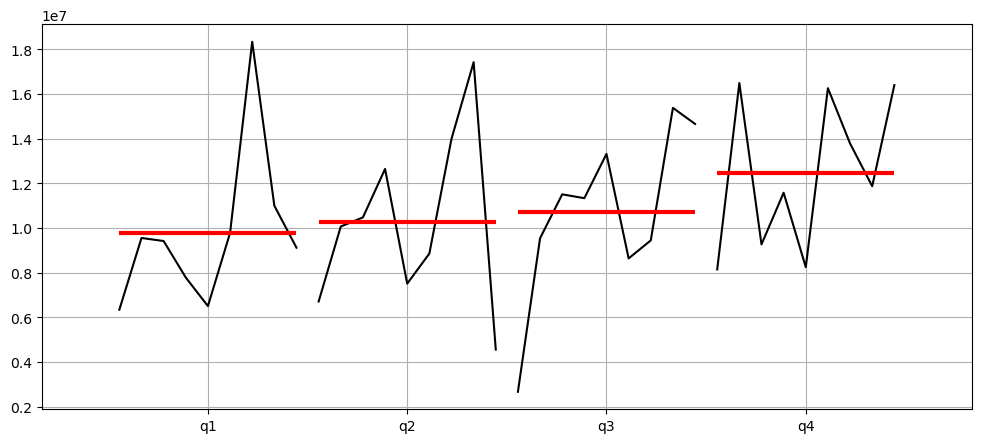

In [27]:
# Plot the quarterly data using quarter_plot
quarter_plot(hist_q['TOTAL']);

# 4 - Train and evaluate models
Next we will evaluate the performance of 4 models: Holt - Winters, ARMA, SARIMAX and prophet to determine which offers a better prediction.

In [28]:
# ----------------------- WEEKS --------------------------------------------
# Extract complete data
all_data = hist_w['TOTAL']

# Set the start and end indices for the test data (test has 26 weeks... half year)
start = len(all_data) - 26
end = len(all_data) - 1

# Split the data into train and test sets 
train_data = all_data.iloc[:start]
test_data = all_data.iloc[start:]
# --------------------------------------------------------------------------


# ----------------------- MONTHS --------------------------------------------
# Extract complete data
#all_data = hist_m['TOTAL']

# Split the data into train and test sets (test has 52 weeks... a year)
#train_data = all_data.iloc[:94]
#test_data = all_data.iloc[94:]

This function will be of great help to show the metrics and evaluate the results of each model.

In [29]:
def models_evaluation(models: dict, real, errors=False):
    """
    Evaluate forecasting models and compare their results with the actual values.

    Parameters
    ----------
        models (dict): A dictionary containing the forecasting models values (Pandas.Series) as dictvalues 
            and their names as keys.
        
        real (Pandas Series): The series containing the actual values to compare.
        
        errors: Set true if want to calculate MAE and RMSE. Don't use with forecasted values

    Returns:
        Dictionary if with error if errors=True
    """
    
    # Create dictionary for future dataframe only if errors=True
    if errors:
        dic = {
            'ALGORITHM': [],
            'MAE': [],
            'RMSE': [],
            'MAPE': []}
    
    # Plot the actual values
    real.plot(legend=True,label='REAL',lw=2.0)
    
    # Iterate through the models and compare with the actual values
    for key, values in models.items():
        # Plot the model values
        values.plot(legend=True,label=key);
        
        # Calculate the MAE and RMSE between the actual values and the model values
        if errors:
            mae = np.round(mean_absolute_error(real.values,values.values))
            rmse = np.round(np.sqrt(mean_squared_error(real.values,values.values)))
            mape = np.round(mean_absolute_percentage_error(real.values,values.values),4)

            # fill dictionary with data
            dic['ALGORITHM'].append(key)
            dic['MAE'].append(mae)
            dic['RMSE'].append(rmse)
            dic['MAPE'].append(mape)
            
    return pd.DataFrame(dic) if errors else None

## 4.2 Holt - Winters

In [30]:
# Check frequency (W-SUN)
hist_w.index

DatetimeIndex(['2014-08-10', '2014-08-17', '2014-08-24', '2014-08-31',
               '2014-09-07', '2014-09-14', '2014-09-21', '2014-09-28',
               '2014-10-05', '2014-10-12',
               ...
               '2023-03-19', '2023-03-26', '2023-04-02', '2023-04-09',
               '2023-04-16', '2023-04-23', '2023-04-30', '2023-05-07',
               '2023-05-14', '2023-05-21'],
              dtype='datetime64[ns]', name='DATE', length=459, freq='W-SUN')

dummy evaluation as hyperparameter grid search with the entire data

,ALGORITHM,MAE,RMSE,MAPE
0,HW_2_add,522603.0,809509.0,1.0526
1,HW_2_mul,699110.0,1082608.0,1.4755
2,HW_3_add_add,483833.0,768069.0,0.9838


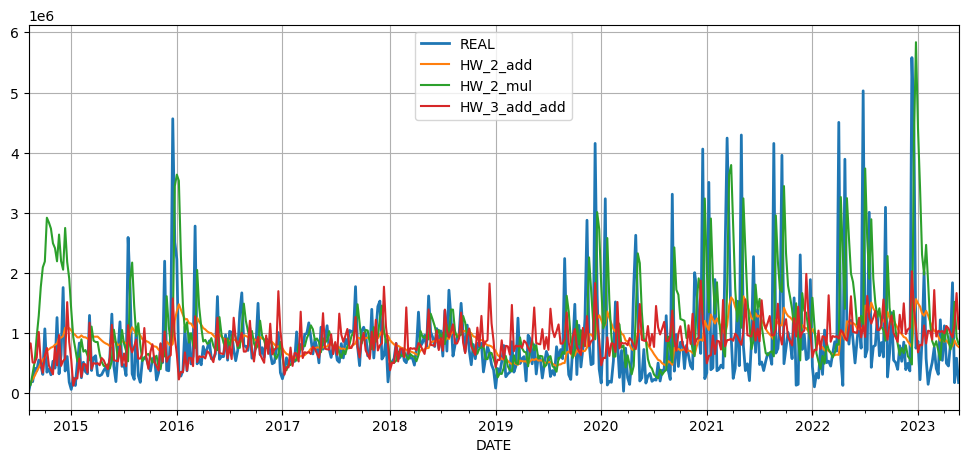

In [31]:
# Harmless warning
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Fit the Exponential Smoothing models
HW_2rd_add = ExponentialSmoothing(all_data,trend='add').fit()
HW_2rd_mul = ExponentialSmoothing(all_data,trend='mul').fit()
HW_3rd_add_add = ExponentialSmoothing(all_data,trend='add',seasonal='add',seasonal_periods=52).fit()

# There is an strange overflow RuntimeWarning with this model:
#HW_3rd_mul_add = ExponentialSmoothing(hist_w['TOTAL'],trend='mul',seasonal='add',seasonal_periods=52).fit()

# Create a dictionary of model names and their fitted values
models = {
    'HW_2_add': HW_2rd_add.fittedvalues,
    'HW_2_mul': HW_2rd_mul.fittedvalues,
    'HW_3_add_add': HW_3rd_add_add.fittedvalues,
    #'HW_3rd_mul_add': HW_3rd_mul_add.fittedvalues
}

# Evaluate the models to select decomposition type (mul,add) and order
models_evaluation(models,all_data,errors=True)

It has been decided to use triple exponential smoothing with both additive components, trend and seasonality since they offer the lowest MAE, RMSE and MAPE.

,ALGORITHM,MAE,RMSE,MAPE
0,Holt - Winters,777735.0,1093889.0,1.4744


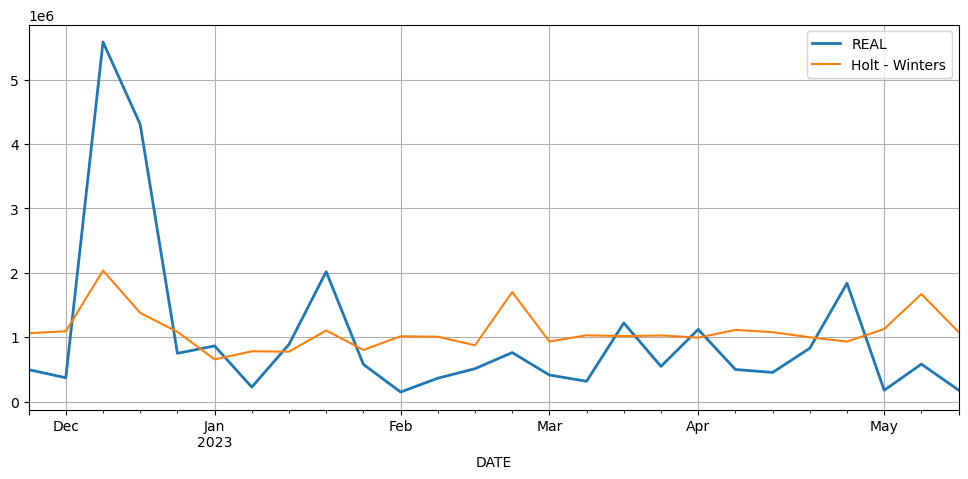

In [32]:
# Fit the Exponential Smoothing model to the training data
fitted_model_HW = ExponentialSmoothing(train_data,trend='add',seasonal='add').fit()

# Generate test predictions using the fitted model
test_predictions_HW = fitted_model_HW.predict(start=start,end=end)

# Create a dictionary of the test model's predictions.
test_model_dict = {
    'Holt - Winters': test_predictions_HW}

# Evaluate on the test_data
models_evaluation(test_model_dict,test_data,errors=True)

Not bad for a time series with so much noise

In [33]:
# Mean comparation
print(f'Mean of the test set: {test_data.mean()}')
print(f'Mean of the predicted values: {test_predictions_HW.mean()}')

Mean of the test set: 1001467.2434615383
Mean of the predicted values: 1090973.6347383126


Now we are going to predict based on all the information

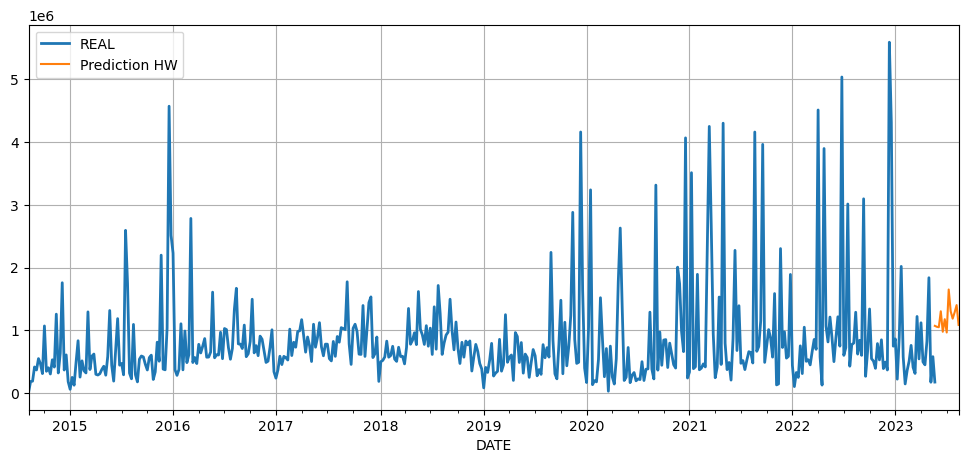

In [34]:
# Fit the Exponential Smoothing model to the entire dataset
fitted_model_HW = ExponentialSmoothing(all_data,trend='add',seasonal='add').fit()

# Generate predictions for future time steps
predictions_HW = fitted_model_HW.predict(start=end,end=end+12)

# Create a dictionary to comparate all models predictions
pred_model_dict = {
    'Prediction HW': predictions_HW}

# Just print (is future, imposible to evaluate)
models_evaluation(pred_model_dict,all_data);

## 4.3 ARMA / ARIMA model
The direct interpretation of ACF plot and the PACF plot suggests using 3 lags in the trend and 1 in the seasonality. It will be better to find these parameters by cross validation (grid search)

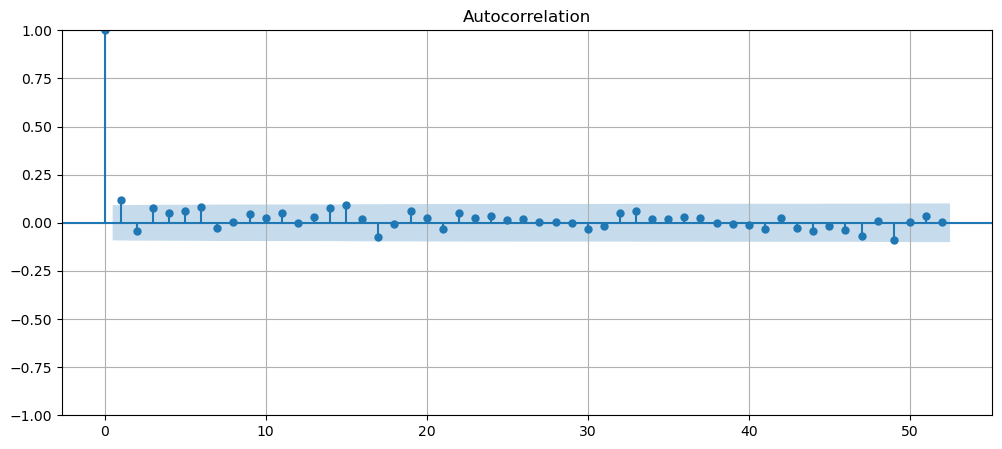

In [35]:
lags = 52
# Plot the autocorrelation function of 52 lags
plot_acf(all_data,lags=lags);

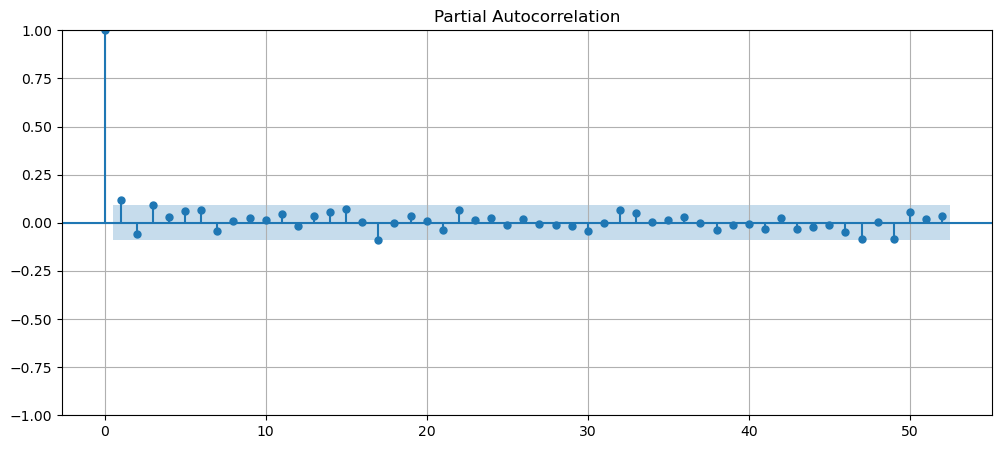

In [36]:
# Plot the partial autocorrelation function of 52 lags
plot_pacf(all_data,lags=lags,method='ywm');

In [37]:
# Use the auto_arima function to automatically select the best ARIMA model
auto_arima(all_data,start_p=0,start_q=0,max_p=6,
           max_q=6,seasonal=False,d=None,
           suppress_warnings=True,stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  459
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -6865.738
Date:                Fri, 16 Jun 2023   AIC                          13745.476
Time:                        16:09:08   BIC                          13774.364
Sample:                    08-10-2014   HQIC                         13756.853
                         - 05-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1098      0.038      2.861      0.004       0.035       0.185
ar.L2         -0.0891      0.066     -1.341      0.180      -0.219       0.041
ar.L3          0.0740      0.040      1.856      0.063      -0.004       0.152
ar.L4          0.0040      0.039      0.103      0.918      -0.072       0.080
ar.L5          0.0473      0.056      0.848      0.396      -0.062       0.157
ma.L1         -0.9833      0.011    -88.235      0.000      -1.005      -0.961
sigma2      6.806e+11   4.77e-14   1.43e+25      0.000    6.81e+11    6.81e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2392.86
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               3.95   Skew:                             2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.65e+40. Standard errors may be unstable.
"""

,ALGORITHM,MAE,RMSE,MAPE
0,Holt - Winters,777735.0,1093889.0,1.4744
1,ARMA,690147.0,1257843.0,1.0528


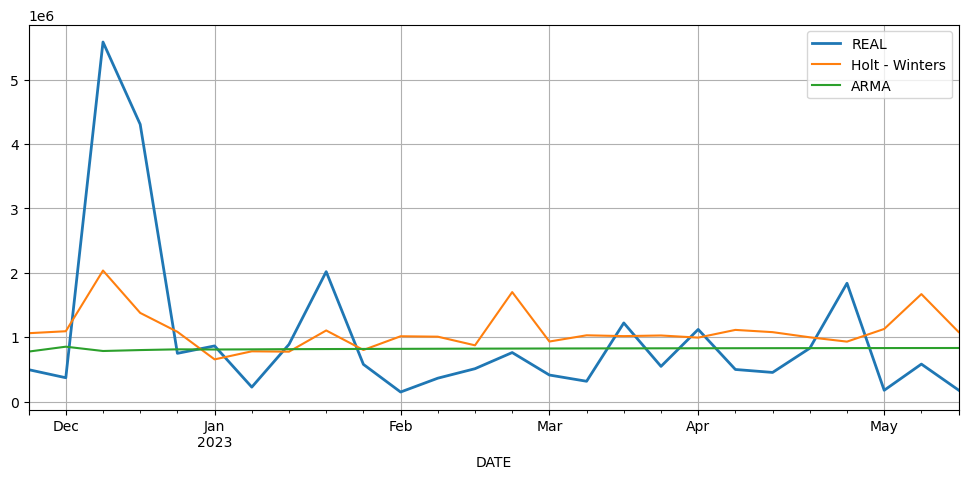

In [38]:
# Fit an ARMA model to the training data
fitted_model_ARMA = ARIMA(train_data,order=(5,0,1)).fit()

# Generate predictions for the test data
test_predictions_ARMA = fitted_model_ARMA.predict(start=start,end=end)

# Add the ARMA predictions to the test_model_dict dictionary
test_model_dict['ARMA'] = test_predictions_ARMA

# Evaluate on the test_data
models_evaluation(test_model_dict,test_data,errors=True)

**NOTE**: I did the test with differentiation 1 and the results are definitely worse. the Dickey-Fuller test is a powerful tool.

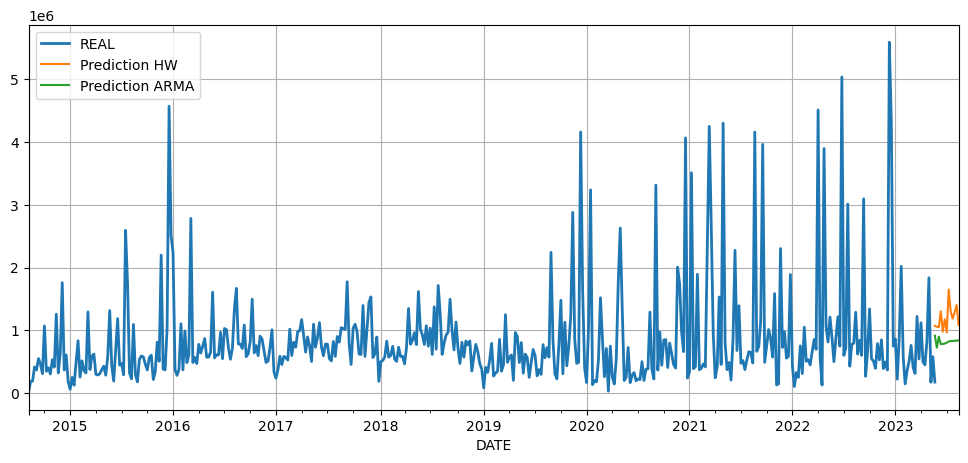

In [39]:
# Fit the ARMA Smoothing model to the entire dataset
fitted_model_ARMA = ARIMA(all_data,order=(5,0,1)).fit()

# Generate predictions for future time steps
predictions_ARMA = fitted_model_ARMA.predict(start=end,end=end + 12)

# Add the ARMA predictions to the pred_model_dict (FUTURE DATA) dictionary
pred_model_dict['Prediction ARMA'] = predictions_ARMA
models_evaluation(pred_model_dict,all_data);

## 4.4 - SARIMA
Without valid seasonal component this model is not viable

## 4.5 SARIMAX
For this first approach we do not have much information that we can use as exogenous variables. However, it was observed that the average sales for each month have notable differences. We are going to add these months as exogenous variables to give the model more dynamism.

In [40]:
# Get month name from index
hist_w['MONTH'] = hist_w.index.month_name()

# Create dummy for the exogenous variables and save it ass all_data
all_data_dummies = pd.get_dummies(data=hist_w)

# Split the data into train and test sets (test has 52 weeks... a year)
train_data = all_data_dummies.iloc[:start]['TOTAL']
test_data = all_data_dummies.iloc[start:]['TOTAL']

dummies_list = ['MONTH_April', 'MONTH_August', 'MONTH_December', 'MONTH_January',
       'MONTH_February', 'MONTH_July', 'MONTH_June', 'MONTH_March', 'MONTH_May',
       'MONTH_November', 'MONTH_October', 'MONTH_September']

train_data_exog = all_data_dummies.iloc[:start][dummies_list]
test_data_exog = all_data_dummies.iloc[start:][dummies_list]

The SARIMAX results show greater dynamism and a correct response to the months of the year. The results show better numbers than the ARMA model in all metrics and outperform the Holt-Winters algorithm in the MAE. Likewise, the algorithm is more robust to data noise (higher RMSE) which helps to reduce overfitting.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49235D+01    |proj g|=  5.18718D-03


 This problem is unconstrained.



At iterate    5    f=  1.49228D+01    |proj g|=  2.40874D-02

At iterate   10    f=  1.49186D+01    |proj g|=  1.40879D-02

At iterate   15    f=  1.49177D+01    |proj g|=  1.28918D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     18     22      1     0     0   8.606D-06   1.492D+01
  F =   14.917659310031102     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


,ALGORITHM,MAE,RMSE,MAPE
0,Holt - Winters,777735.0,1093889.0,1.4744
1,ARMA,690147.0,1257843.0,1.0528
2,SARIMAX,686237.0,1208805.0,1.0008


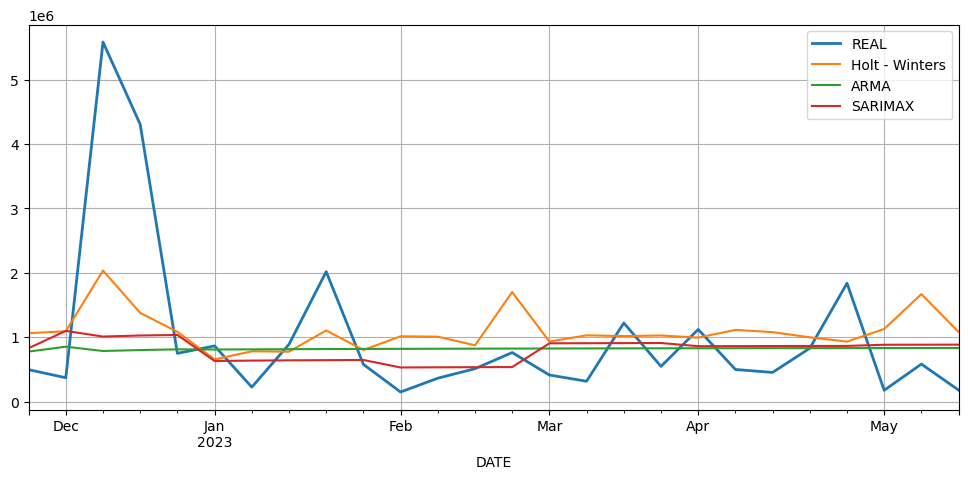

In [41]:
# Fit model with exogenous variables
fitted_model_SARIMAX = SARIMAX(endog=train_data,exog=train_data_exog,order=(5,0,1)).fit()

# Generate predictions for the test data
test_predictions_SARIMAX = fitted_model_SARIMAX.predict(start=start,end=end,exog=test_data_exog)

# Add the ARMA predictions to the test_model_dict dictionary
test_model_dict['SARIMAX'] = test_predictions_SARIMAX

# Evaluate on the test_data
models_evaluation(test_model_dict,test_data,errors=True)

To obtain predictions it is necessary to manufacture the exogenous variables with exactly the same arrangement as the original ones.

In [42]:
def get_exog_months(data,periods):
    """
    Generate exogenous variables for future months based on the specified number of periods.
    
    Parameters:
        data (DataFrame): Original DataFrame with a datetime index and freq previously specified.
        periods (int): Number of periods to generate.
    
    Returns:
        DataFrame: DataFrame containing one-hot encoded month values for future dates.
    """
    
    # Generate future dates based on the specified number of periods and the frequency of the data
    future_dates = pd.date_range(start=data.index[len(data) - 1],periods=periods,freq=data.index.freqstr)
    # Append the future dates to the index of the original data
    index = data.index.append(future_dates)
    
    dataframe = pd.DataFrame(data=index.month_name(),index=index,columns=['MES'])
    # Convert the month names into dummy variables using one-hot encoding
    dataframe = pd.get_dummies(dataframe)
    
    # Return the last 'periods' number of rows from the DataFrame
    return dataframe.iloc[-periods:]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49639D+01    |proj g|=  6.58602D-03


 This problem is unconstrained.



At iterate    5    f=  1.49617D+01    |proj g|=  2.58349D-02

At iterate   10    f=  1.49592D+01    |proj g|=  8.41109D-03

At iterate   15    f=  1.49587D+01    |proj g|=  3.57064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     19     23      1     0     0   1.158D-05   1.496D+01
  F =   14.958707619464525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


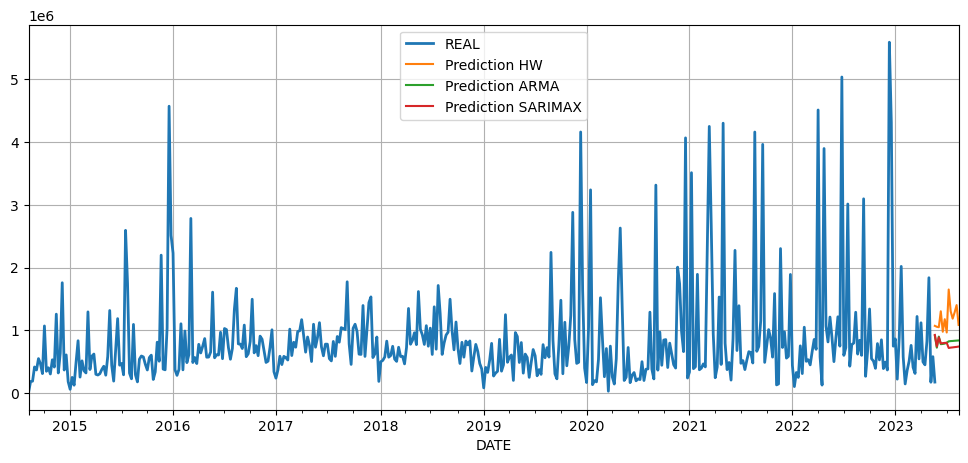

In [43]:
# Fit the ARMA Smoothing model to the entire dataset
fitted_model_SARIMAX = SARIMAX(endog=all_data,exog=all_data_dummies[dummies_list],order=(5,0,1)).fit()

# Get exogenous variables
exog = get_exog_months(all_data,12)

# Generate predictions for future time steps
predictions_SARIMAX = fitted_model_SARIMAX.predict(start=end,end=end + 12,exog=exog)

# Add the ARMA predictions to the pred_model_dict (FUTURE DATA) dictionary
pred_model_dict['Prediction SARIMAX'] = predictions_SARIMAX
models_evaluation(pred_model_dict,all_data);

If we want more accuracy we requied more complex models and especially exogenous variables (useful additional data). We're going to test tools like neural networks and prophet just to see if any of them offer useful information. From here it is mere experimentation and curiosity, at the same time it is intended to extract valuable information with the help of the experience of the people directly related to this company for the training and validation of a more complex hybrid model.

## 4.6 Deep learning (neural networks)
it's like a bazooka trying to kill a fly. Let's put it aside

## 4.7 Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. The original paper is incredible: [LINK](https://peerj.com/preprints/3190/)

In [44]:
# Create a DataFrame for Prophet (this format is required)
all_data_prophet = pd.DataFrame({
    'ds': all_data.index,
    'y': all_data.values})

# Split the data into training and test sets
train_data_prophet = all_data_prophet.iloc[:start]
test_data_prophet = all_data_prophet.iloc[start:]

# Fit the Prophet model to the training data
fitted_model_PROPHET = Prophet().fit(train_data_prophet)

16:09:19 - cmdstanpy - INFO - Chain [1] start processing
16:09:19 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# Create a future dataframe for making predictions (half year)
# Dataframe include previous dates (prophet format)
future = fitted_model_PROPHET.make_future_dataframe(periods=26,freq='W-SUN')

# Use the fitted model to make predictions on the future dataframe
forecast = fitted_model_PROPHET.predict(future)

,ALGORITHM,MAE,RMSE,MAPE
0,Holt - Winters,777735.0,1093889.0,1.4744
1,ARMA,690147.0,1257843.0,1.0528
2,SARIMAX,686237.0,1208805.0,1.0008
3,PROPHET,782732.0,1160702.0,1.4921


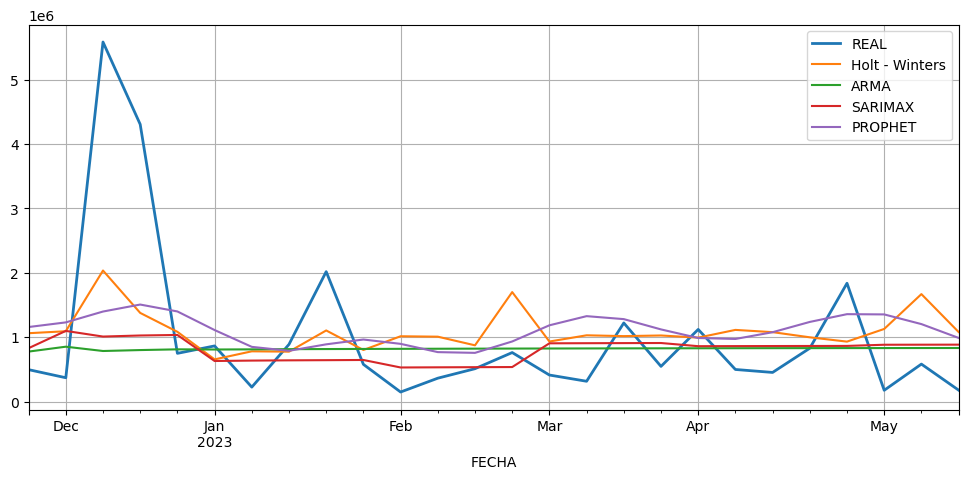

In [46]:
# Manipulate the dataframe so that it has the same format as the other models 
test_predictions_PROPHET = forecast.tail(26)[['ds','yhat']]
test_predictions_PROPHET.columns = ['FECHA','TOTAL']
test_predictions_PROPHET = test_predictions_PROPHET.set_index('FECHA')['TOTAL']

# Add the PROPHET predictions to the test_model_dict dictionary
test_model_dict['PROPHET'] = test_predictions_PROPHET

# Evaluate on the test_data
models_evaluation(test_model_dict,test_data,errors=True)

### 4.7.1 hyperparameter tuning
Didn't work as expected

In [47]:
# -------------- VERY HIGH CPU LOAD -------------------

#from prophet.diagnostics import cross_validation
#from prophet.diagnostics import performance_metrics
#import itertools

#param_grid = {  
#    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#    'seasonality_mode': ['additive', 'multiplicative']
#}

# Generate all combinations of parameters
#all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
#rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
#for params in all_params:
#    m = Prophet(**params).fit(train_data_prophet)  # Fit model with given params
#    df_cv = cross_validation(m, horizon='182 days', parallel="processes")
#    df_p = performance_metrics(df_cv, rolling_window=1)
#    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
#tuning_results = pd.DataFrame(all_params)
#tuning_results['rmse'] = rmses
#print(tuning_results)

In [48]:
#best_params = {
#    'changepoint_prior_scale': 0.1, 
#    'seasonality_prior_scale': 0.01,
#    'seasonality_mode': 'multiplicative'
#}

#best_params = all_params[np.argmin(rmses)]
#print(best_params)

In [49]:
#fitted_model_PROPHET = Prophet(**best_params).fit(train_data_prophet)
#forecast = fitted_model_PROPHET.predict(future)

# Manipulate the dataframe so that it has the same format as the other models 
#test_predictions_PROPHET = forecast.tail(26)[['ds','yhat']]
#test_predictions_PROPHET.columns = ['FECHA','TOTAL']
#test_predictions_PROPHET = test_predictions_PROPHET.set_index('FECHA')['TOTAL']

# Add the PROPHET predictions to the test_model_dict dictionary
#test_model_dict['PRUEBA PROPHET'] = test_predictions_PROPHET

# Evaluate on the test_data
#models_evaluation(test_model_dict,test_data,errors=True)

16:09:22 - cmdstanpy - INFO - Chain [1] start processing
16:09:22 - cmdstanpy - INFO - Chain [1] done processing


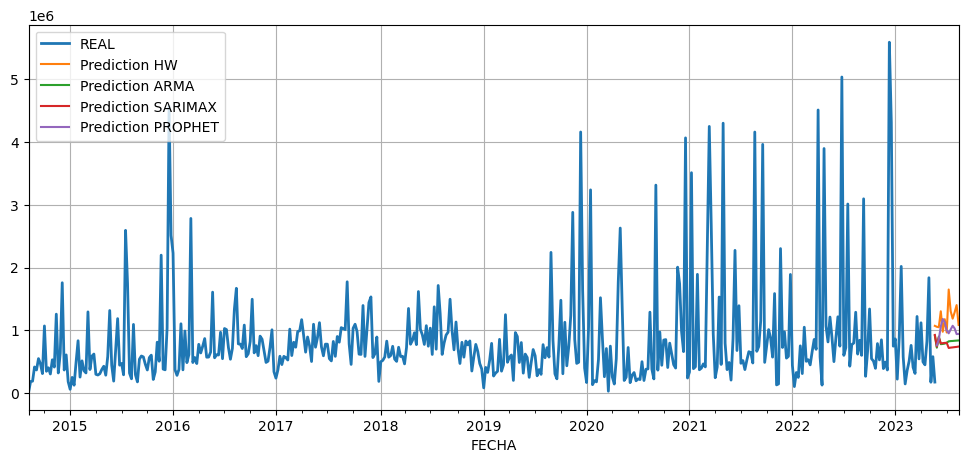

In [50]:
# Fit the Prophet model to the entire dataset
fitted_model_PROPHET = Prophet().fit(all_data_prophet)

# Create a future dataframe for making predictions (half year)
# Dataframe include previous dates (prophet format)
future = fitted_model_PROPHET.make_future_dataframe(periods=12,freq='W-SUN')

# Use the fitted model to make predictions on the future dataframe
forecast = fitted_model_PROPHET.predict(future)

# Manipulate the dataframe so that it has the same format as the other models 
predictions_PROPHET = forecast.tail(12)[['ds','yhat']]
predictions_PROPHET.columns = ['FECHA','TOTAL']
predictions_PROPHET = predictions_PROPHET.set_index('FECHA')['TOTAL']

# Add the PROPHET predictions to the pred_model_dict (FUTURE DATA) dictionary
pred_model_dict['Prediction PROPHET'] = predictions_PROPHET
models_evaluation(pred_model_dict,all_data);

# 5 - Model selection and output configuration
We are going to use prophet for its good ratio of MAE and RMS, it follows the real trend per month, it is not as susceptible to noise as HW, it has more dynamism than SARIMAX, the preprocessing is easier (it does not require exogenous) and it calculates reliability margins. for later graphing.

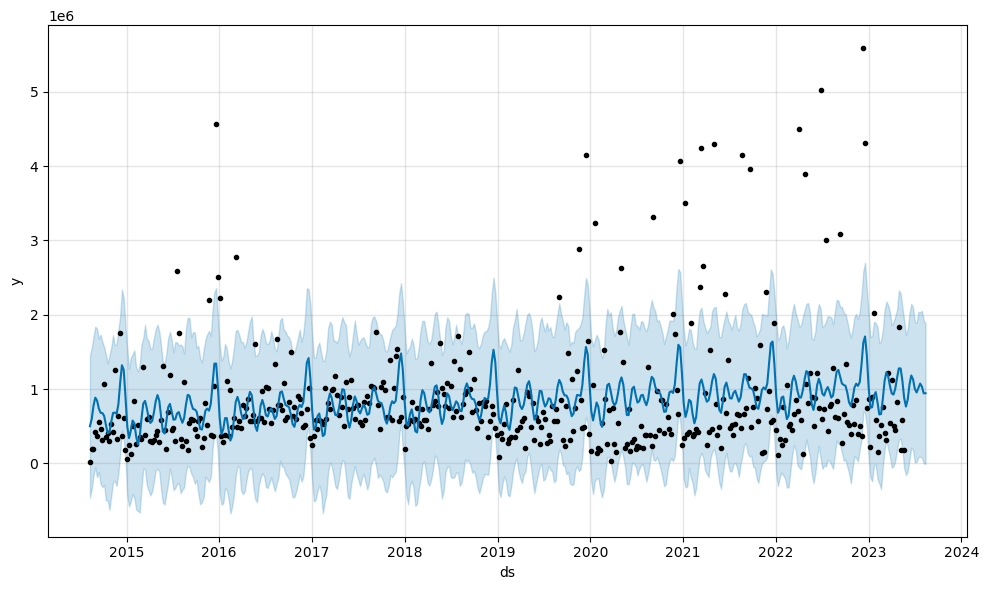

In [51]:
fitted_model_PROPHET.plot(forecast);

## 5.1 Output
A function is used to format the from prophet. Since the other models have the same structure, it is easier to migrate from one to another.

In [52]:
def format_prophet(forecast,periods,freq='W-SUN',cvs_name='prediction'):
    """
    Format the Prophet forecast data and save it to a CSV file.

    Parameters:
        forecast (DataFrame): The forecast data obtained from Prophet.
        periods (int): The number of periods to include in the formatted data.
        freq (str): The frequency of the data. Default is 'W-SUN'.
        cvs_name (str): The name of the CSV file to save the formatted data. Default is 'prediction'.

    Returns:
        DataFrame: The formatted prediction data with 'FECHA' as the index.

    """
    # Extract the relevant columns from the forecast
    predicted_data = forecast.tail(periods)[['ds','yhat','yhat_lower','yhat_upper']]
    
    # Create a dictionary for the formatted prediction data
    dic = {
    'DATE': predicted_data['ds'],
    'PRED': predicted_data['yhat'],
    'MIN': predicted_data['yhat_lower'],
    'MAX': predicted_data['yhat_upper']}
    
    # Create a DataFrame from the dictionary with DATE as index with specified freq
    prediction_formated = pd.DataFrame(dic)
    prediction_formated.set_index('DATE',inplace=True)
    prediction_formated.index.freq = freq
    
    # Save the formatted prediction to a CSV file
    #prediction_formated.to_csv('../OUTPUT/'+cvs_name+'.csv')
    return prediction_formated

In [53]:
def make_output(pred,hist,prev_periods=208):
    """
    Plot the actual values, prediction, and uncertainty.

    Parameters:
        pred (DataFrame): The predicted values with 'PRED', 'MIN', and 'MAX' columns.
        hist (DataFrame): The historical data with 'TOTAL' column.
        prev_periods (int): The number of previous periods to plot. Default is 208.

    """ 
    # Plot the actual values
    figure = plt.figure(figsize=(12,5),dpi=150)
    
    sns.set(style='dark')
    sns.lineplot(y=hist.tail(prev_periods)['TOTAL'],x=hist.tail(prev_periods).index,label='Historical')
    sns.lineplot(y=pred['PRED'],x=pred.index,color='red',label='Prediction')
    
    plt.fill_between(pred.index,pred['MAX'],pred['MIN'],alpha=0.3,label='Uncertainty')
    
    #hist.tail(prev_periods)['TOTAL'].plot(legend=True,label='Historico',lw=2.0)
    #pred['PRED'].plot(legend=True,label='Prediccion',lw=1.5)

    plt.ylabel('Total sales')
    plt.xlabel('Date')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.title('Total sales and prediction (millions of MXN)')
    #plt.savefig('../OUTPUT/figures/final.png')

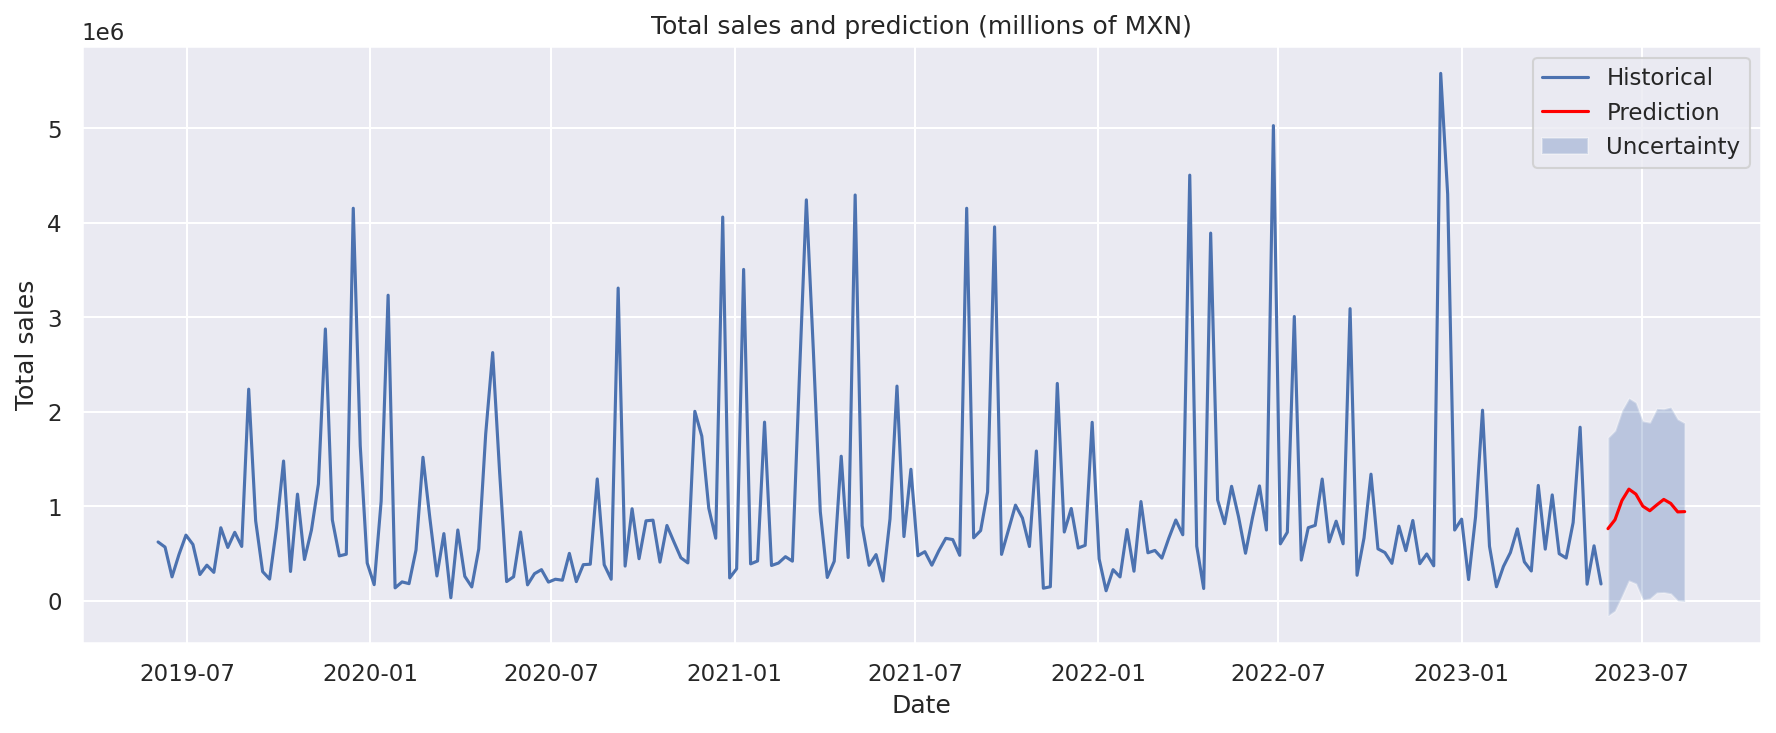

In [54]:
predictions_ready = format_prophet(forecast,12)
make_output(predictions_ready,hist_w)

# The End